In [55]:
import numpy as np
import pandas as pd
from scipy.cluster.hierarchy import linkage, dendrogram, fcluster
from scipy.spatial.distance import squareform
from scipy.signal import savgol_filter as savgol
from scipy.integrate import solve_ivp
from copy import deepcopy
import cvxpy as cp
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import cm
npg_colors = ['#00A087FF','#E64B35FF','#3C5488FF','#4DBBD5FF','#F39B7FFF','#8491B4FF','#91D1C2FF','#DC0000FF','#7E6148FF','#B09C85FF']
plt.rcParams.update({'font.size':18});
plt.rc('lines',linewidth=4);
plt.rcParams['axes.spines.right'] = False
plt.rcParams['axes.spines.top'] = False 
figDir = '/Users/aqib/Desktop/ksp_figures/'
plt.rc('axes', axisbelow=True)

from read_PR_data import PR_2_dicts # PR stands for plate reader

In [2]:
def gen_well_keys():
    # generate list of well keys for treatment and control and corresponding tags
    import string
    row_keys = list(string.ascii_uppercase[0:numRows])
    col_keys = range(1,numCols+1)

    from itertools import product
    cartprod = list(product(row_keys,col_keys))

    well_keys = []
    for i in cartprod:
        well_keys.append(str(i[0]+str(i[1])))
    return well_keys

In [3]:
names = ['atpB','petA','anti-sigma 28 factor','sucC','Uncharacterized protein I','rpoA','fabA',
        'Putative ABC transport protein','gltA','Putative outer membrane porin A protein','acrA','lpxC',
        'cspA2','capB','Uncharacterized protein II']
tags = ['PFLU\_6124','PFLU\_0841','PFLU\_4736','PFLU\_1823','PFLU\_3761','PFLU\_5502','PFLU\_1836','PFLU\_0376',
        'PFLU\_1815','PFLU\_0953','PFLU\_1380','PFLU\_4612','PFLU\_4150','PFLU\_1302A','PFLU\_1358']
all_strains = ['6124','0841','4736','1823','3761','5502','1836','0376','1815','0953','1380','4612','4150',
              '1302A','1358']

In [4]:
def get_data(fn,nR,nC,sampling_rate):
    '''
    fn: string of the filename from plate reader. It is a text file that the BioTek instruments output 
    The function PR_2_dicts has code to scrape the file and outputs dictionaries with the well IDs as keys
    (Another tip since the code isn't perfect. Read OD first on the reader, then any fluorescence measurements)
    nR: number of rows (best to have the plate reader sample all rows and columns, because PR_2_dicts will 
    consider the first sampled well as A1, the second as A2 row wise.)
    nC: number of columns
    sampling_rate: The sampling time in minutes 
    '''
    data,numReads = PR_2_dicts(fn,nR,nC) 
    tspan = np.linspace(0,numReads*sampling_rate,numReads)/60 # time in hours
    for ii,measurements in enumerate(data): # will need to adjust this loop for new protocols
        if ii == 0: 
            od = measurements
        elif ii == 1: 
            afu1 = measurements
        elif ii == 2: 
            afu2 = measurements
            
    afu_normed = {}
    for key in afu1: 
        afu_normed[key] = afu1[key]/od[key]
        
    return od,afu1,afu_normed,tspan

def gen_well_keys(nR,nC):
    # generate list of well keys for treatment and control and corresponding tags
    import string
    row_keys = list(string.ascii_uppercase[0:nR])
    col_keys = range(1,nC+1)

    from itertools import product
    cartprod = list(product(row_keys,col_keys))

    well_keys = []
    for i in cartprod:
        well_keys.append(str(i[0]+str(i[1])))
        
    return well_keys

def plot_data(X,tspan,labels,conds,nR,nC,figsize,ic=0,addLegend=False,bboxanchor=(1.125,0.75),
              addLabels=False,xLabel='X',yLabel='Y',xPos=[0.5,-0.5],yPos=[-0.5,0.5],
              savefig=False,savedir='/Users/aqib/Desktop/fig.pdf'): 
    '''
    X: dictionary of data with keys as well locations
    labels: dictionary of strain id: well location pairs
    conds: list of experimental conditions
    nR: number of rows for subplots
    nC: number of columns of subplots
    '''

    fig,axs = plt.subplots(nR,nC,figsize=figsize,sharex=True,sharey='row')
    for ii,ax in enumerate(axs.reshape(-1)):
        if ii < len(labels): # this is necessary because we have to generate a full grid of subplots
            strain = list(labels.keys())[ii] # formerly key
            ax.set_title(strain)
            for jj in range(len(conds)): # number of conditions per strain
                ax.plot(tspan[ic:],savgol(X[labels[strain][jj]][ic:],25,1,axis=0)) # data is smoothed while plotting
            for side in ax.spines.keys(): # top, bottom, left, right
                ax.spines[side].set_linewidth(2) # I often like thick spines
    plt.tight_layout();
    if addLabels: 
        fig.text(xPos[0],xPos[1],xLabel,ha='center');
        fig.text(yPos[0],yPos[1],yLabel,va='center',rotation='vertical');
    if addLegend: 
        fig.legend(conds,frameon=False,bbox_to_anchor=bboxanchor)
    if savefig: 
        plt.savefig(savedir,transparent=True,bbox_inches='tight')
    plt.show()
    
def get_titrations(y,labels,conds):
    '''
    y: data dictionary where key-value pair is well locations: plate reader data (e.g. gfpn, gfp, od)
    labels: dictionary of strain id: well location pairs
    conds: list of experimental conditions
    '''
    titration_dict = {} # key-value pairs, strain label: matrix with cols as cond. and rows as time-series
    for strain,val in labels.items():
        tmp = np.zeros((len(conds),len(tspan))) # building matrix of conditions x time for each strain
        for ii in range(len(conds)): # number of conditions for each strain (key) 
            tmp[ii:ii+1,:] = y[labels[strain][ii]].T
        titration_dict[strain] = tmp
        
    titration_mean = {}
    titration_std = {}
    # first get unique strain names (without replicate number)
    strains = list(set([x.split('_')[0] for x in list(titration_dict.keys())]))
    for strain in strains: 
        titration_mean[strain] = np.mean([titration_dict[strain+'_1'],titration_dict[strain+'_2'],
                                          titration_dict[strain+'_3']],axis=0)
        titration_std[strain] = np.std([titration_dict[strain+'_1'],titration_dict[strain+'_2'],
                                          titration_dict[strain+'_3']],axis=0)        
    
    # compute the fold changes for all the strains at all times
    titration_fc = {}
    fc_tmp = np.zeros((len(conds)-1,len(tspan)))
    for strain in strains: 
        for cond in range(len(conds)-1):
            fc_tmp[cond,:] = titration_mean[strain][cond+1,:]/titration_mean[strain][0,:]
        titration_fc[strain] = fc_tmp
        
    return titration_dict, titration_mean, titration_std, titration_fc

def concat_dicts(dict_all, dict_new): 
    '''
    Add the key-value pairs of dict_new to dict_all and return the updated dict_all
    '''
    for strain,val in dict_new.items():
        dict_all[strain] = val
        
    return dict_all


In [5]:
# the universal datasets will contain data of od normalized gfp. if needed, do the same for od and gfp 
titr_dict = {}
titr_mean_dict = {}
titr_std_dict = {}
titr_fc_dict = {}
od_titr_dict = {}
od_mean_dict = {}
od_std_dict = {}

all_wells = gen_well_keys(8,12) # enumerates all the well keys on a 96 well plate
conds = [str(ii) + ' µL' for ii in range(0,7)] # the spectracide conditions that were used  CONVERT TO mM malathion
conds_mM = [0.0, 0.374, 0.747, 1.12, 1.49, 1.87, 2.24] # molar concentration in millimolar
nConditions = len(conds_mM)

ddir = 'data/malathion-reporter-plate-reader/' # data directory with plate reader curves

######################### 0841 (petA) and 4150 (cspA2) #########################
# generate dictionary with list of well locations and strain id as key 
labels = {'0841_1':all_wells[15:22],'0841_2':all_wells[27:34],'0841_3':all_wells[39:46],
          '4150_1':all_wells[51:58],'4150_2':all_wells[63:70],'4150_3':all_wells[75:82]}
# parse data file
od,gfp,gfpn,tspan = get_data(ddir+'reporter_screen_0841_4150_10.5.21.txt',8,12,3)
# generate a dictionary with keys as strain names and values as od normalized fluorescence and get statistics
titration_dict,titration_mean,titration_std,titration_fc = get_titrations(gfpn,labels,conds)
od_titr, od_mean, od_std, _ = get_titrations(od,labels,conds)
# update the universal datasets
titr_dict,titr_mean_dict,titr_std_dict,titr_fc_dict = concat_dicts(titr_dict,titration_dict), \
                                           concat_dicts(titr_mean_dict,titration_mean), \
                                           concat_dicts(titr_std_dict,titration_std), \
                                           concat_dicts(titr_fc_dict,titration_fc)
od_titr_dict,od_mean_dict,od_std_dict = concat_dicts(od_titr_dict,od_titr), \
                                        concat_dicts(od_mean_dict,od_mean), \
                                        concat_dicts(od_std_dict,od_std)


######################### 5502 (rpoA) and 1358 (uncharacterized protein II) #########################
# generate dictionary with list of well locations and strain id as key 
labels = {'5502_1':all_wells[15:22],'5502_2':all_wells[27:34],'5502_3':all_wells[39:46],
          '1358_1':all_wells[51:58],'1358_2':all_wells[63:70],'1358_3':all_wells[75:82]}
# parse data file
od,gfp,gfpn,tspan = get_data(ddir+'reporter_screen_5502_1358_10.6.21.txt',8,12,3)
# generate a dictionary with keys as strain names and values as od normalized fluorescence and get statistics
titration_dict,titration_mean,titration_std,titration_fc = get_titrations(gfpn,labels,conds)
od_titr, od_mean, od_std, _ = get_titrations(od,labels,conds)
# update the universal datasets
titr_dict,titr_mean_dict,titr_std_dict,titr_fc_dict = concat_dicts(titr_dict,titration_dict), \
                                           concat_dicts(titr_mean_dict,titration_mean), \
                                           concat_dicts(titr_std_dict,titration_std), \
                                           concat_dicts(titr_fc_dict,titration_fc)
od_titr_dict,od_mean_dict,od_std_dict = concat_dicts(od_titr_dict,od_titr), \
                                        concat_dicts(od_mean_dict,od_mean), \
                                        concat_dicts(od_std_dict,od_std)


######################### 6124 (atpB) and 1823 (sucC) #########################
# generate dictionary with list of well locations and strain id as key 
labels = {'6124_1':all_wells[15:22],'6124_2':all_wells[27:34],'6124_3':all_wells[39:46],
          '1823_1':all_wells[51:58],'1823_2':all_wells[63:70],'1823_3':all_wells[75:82]}
# parse data file
od,gfp,gfpn,tspan = get_data(ddir+'reporter_screen_6124_1823_10.7.21.txt',8,12,3)
# generate a dictionary with keys as strain names and values as od normalized fluorescence and get statistics
titration_dict,titration_mean,titration_std,titration_fc = get_titrations(gfpn,labels,conds)
od_titr, od_mean, od_std, _ = get_titrations(od,labels,conds)
# update the universal datasets
titr_dict,titr_mean_dict,titr_std_dict,titr_fc_dict = concat_dicts(titr_dict,titration_dict), \
                                           concat_dicts(titr_mean_dict,titration_mean), \
                                           concat_dicts(titr_std_dict,titration_std), \
                                           concat_dicts(titr_fc_dict,titration_fc)
od_titr_dict,od_mean_dict,od_std_dict = concat_dicts(od_titr_dict,od_titr), \
                                        concat_dicts(od_mean_dict,od_mean), \
                                        concat_dicts(od_std_dict,od_std)


######################### 1836 (fabA) and 0376 (putative ABC transport system, exported protein) #########################
# generate dictionary with list of well locations and strain id as key 
labels = {'1836_1':all_wells[15:22],'1836_2':all_wells[27:34],'1836_3':all_wells[39:46],
          '0376_1':all_wells[51:58],'0376_2':all_wells[63:70],'0376_3':all_wells[75:82]}
# parse data file
od,gfp,gfpn,tspan = get_data(ddir+'reporter_screen_1836_0376_10.8.21.txt',8,12,3)
# generate a dictionary with keys as strain names and values as od normalized fluorescence and get statistics
titration_dict,titration_mean,titration_std,titration_fc = get_titrations(gfpn,labels,conds)
od_titr, od_mean, od_std, _ = get_titrations(od,labels,conds)
# update the universal datasets
titr_dict,titr_mean_dict,titr_std_dict,titr_fc_dict = concat_dicts(titr_dict,titration_dict), \
                                           concat_dicts(titr_mean_dict,titration_mean), \
                                           concat_dicts(titr_std_dict,titration_std), \
                                           concat_dicts(titr_fc_dict,titration_fc)
od_titr_dict,od_mean_dict,od_std_dict = concat_dicts(od_titr_dict,od_titr), \
                                        concat_dicts(od_mean_dict,od_mean), \
                                        concat_dicts(od_std_dict,od_std)


######################### 1836 (fabA) and 0376 (putative ABC transport system, exported protein) #########################
# generate dictionary with list of well locations and strain id as key 
labels = {'4736_1':all_wells[15:22],'4736_2':all_wells[27:34],'4736_3':all_wells[39:46],
          '1815_1':all_wells[51:58],'1815_2':all_wells[63:70],'1815_3':all_wells[75:82]}
# parse data file
od,gfp,gfpn,tspan = get_data(ddir+'reporter_screen_4736_1815_10.9.21.txt',8,12,3)
# generate a dictionary with keys as strain names and values as od normalized fluorescence and get statistics
titration_dict,titration_mean,titration_std,titration_fc = get_titrations(gfpn,labels,conds)
od_titr, od_mean, od_std, _ = get_titrations(od,labels,conds)
# update the universal datasets
titr_dict,titr_mean_dict,titr_std_dict,titr_fc_dict = concat_dicts(titr_dict,titration_dict), \
                                           concat_dicts(titr_mean_dict,titration_mean), \
                                           concat_dicts(titr_std_dict,titration_std), \
                                           concat_dicts(titr_fc_dict,titration_fc)
od_titr_dict,od_mean_dict,od_std_dict = concat_dicts(od_titr_dict,od_titr), \
                                        concat_dicts(od_mean_dict,od_mean), \
                                        concat_dicts(od_std_dict,od_std)


######################### 4612 (putative outer membrane porin protein A) and 1380 (acrA) #########################
# generate dictionary with list of well locations and strain id as key 
labels = {'4612_1':all_wells[15:22],'4612_2':all_wells[27:34],'4612_3':all_wells[39:46],
          '1380_1':all_wells[51:58],'1380_2':all_wells[63:70],'1380_3':all_wells[75:82]}
# parse data file
od,gfp,gfpn,tspan = get_data(ddir+'reporter_screen_4612_1380_10.11.21.txt',8,12,3)
# generate a dictionary with keys as strain names and values as od normalized fluorescence and get statistics
titration_dict,titration_mean,titration_std,titration_fc = get_titrations(gfpn,labels,conds)
od_titr, od_mean, od_std, _ = get_titrations(od,labels,conds)
# update the universal datasets
titr_dict,titr_mean_dict,titr_std_dict,titr_fc_dict = concat_dicts(titr_dict,titration_dict), \
                                           concat_dicts(titr_mean_dict,titration_mean), \
                                           concat_dicts(titr_std_dict,titration_std), \
                                           concat_dicts(titr_fc_dict,titration_fc)
od_titr_dict,od_mean_dict,od_std_dict = concat_dicts(od_titr_dict,od_titr), \
                                        concat_dicts(od_mean_dict,od_mean), \
                                        concat_dicts(od_std_dict,od_std)


######################### 1302A (capB) and 3761 (uncharacterized protein I) #########################
# generate dictionary with list of well locations and strain id as key 
labels = {'1302A_1':all_wells[15:22],'1302A_2':all_wells[27:34],'1302A_3':all_wells[39:46],
          '3761_1':all_wells[51:58],'3761_2':all_wells[63:70],'3761_3':all_wells[75:82]}
# parse data file
od,gfp,gfpn,tspan = get_data(ddir+'reporter_screen_1302A_3761_10.12.21.txt',8,12,3)
# generate a dictionary with keys as strain names and values as od normalized fluorescence and get statistics
titration_dict,titration_mean,titration_std,titration_fc = get_titrations(gfpn,labels,conds)
od_titr, od_mean, od_std, _ = get_titrations(od,labels,conds)
# update the universal datasets
titr_dict,titr_mean_dict,titr_std_dict,titr_fc_dict = concat_dicts(titr_dict,titration_dict), \
                                           concat_dicts(titr_mean_dict,titration_mean), \
                                           concat_dicts(titr_std_dict,titration_std), \
                                           concat_dicts(titr_fc_dict,titration_fc)
od_titr_dict,od_mean_dict,od_std_dict = concat_dicts(od_titr_dict,od_titr), \
                                        concat_dicts(od_mean_dict,od_mean), \
                                        concat_dicts(od_std_dict,od_std)


######################### 0953 (lpxC) and 5598 (oprI) #########################
# generate dictionary with list of well locations and strain id as key 
labels = {'0953_1':all_wells[15:22],'0953_2':all_wells[27:34],'0953_3':all_wells[39:46],
          '5598_1':all_wells[51:58],'5598_2':all_wells[63:70],'5598_3':all_wells[75:82]}
# parse data file
od,gfp,gfpn,tspan = get_data(ddir+'reporter_screen_0953_5598_10.14.21.txt',8,12,3)
# generate a dictionary with keys as strain names and values as od normalized fluorescence and get statistics
titration_dict,titration_mean,titration_std,titration_fc = get_titrations(gfpn,labels,conds)
od_titr, od_mean, od_std, _ = get_titrations(od,labels,conds)
# update the universal datasets
titr_dict,titr_mean_dict,titr_std_dict,titr_fc_dict = concat_dicts(titr_dict,titration_dict), \
                                           concat_dicts(titr_mean_dict,titration_mean), \
                                           concat_dicts(titr_std_dict,titration_std), \
                                           concat_dicts(titr_fc_dict,titration_fc)
od_titr_dict,od_mean_dict,od_std_dict = concat_dicts(od_titr_dict,od_titr), \
                                        concat_dicts(od_mean_dict,od_mean), \
                                        concat_dicts(od_std_dict,od_std)

# PUT NEW DATA HERE PLEASE and follow above formatting #

# also add the gene names below for any newly added data to the universal data dictionaries

all_strains = list(titr_mean_dict.keys())
gene_names = {'4150':'cspA2','0841':'petA','1358':'uncharacterized \n protein II','5502':'rpoA','1823':'sucC',
             '6124':'atpB','0376':'Putative ABC transport \n system','1836':'fabA',
              '4736':'anti-sigma \n 28 factor','1815':'gltA','1380':'acrA',
              '4612':'Putative outer membrane \n porin A','3761':'uncharacterized \n protein I',
             '1302A':'capB','0953':'lpxC','5598':'pqqA',} 

# compute the fold changes for all the strains at all times with respect to the negative control
titr_fc_dict = {}
for strain in all_strains:
    fctmp = np.zeros((len(conds),len(tspan)))
    for cond in range(len(conds)):
        fctmp[cond,:] = titr_mean_dict[strain][cond,:]/titr_mean_dict[strain][0,:]
    titr_fc_dict[strain] = fctmp 
    
nSamples = 500

#### LASSO for virtual sensor optimization 

In [6]:
def loss_fn(X, Y, beta):
    return cp.norm2(X @ beta - Y)**2 

def mse(X, Y, beta):
    return (1.0 / X.shape[0]) * loss_fn(X, Y, beta).value

def regularizer(beta):
    return cp.norm1(beta) 

def objective_fn(X, Y, beta, lambd):
    return loss_fn(X, Y, beta) + lambd * regularizer(beta)

In [84]:
# collect the state data
# choose only one condition for each strain (for now the max mal condition)

S = np.zeros((len(all_strains),nSamples))
for ii,strain in enumerate(all_strains):
    S[ii:ii+1,:] = titr_fc_dict[strain][-1,:nSamples]
S = S.T

vs_strains = []
for ii, strain in enumerate(all_strains):
    for jj in range(nConditions-6):
        kk = jj + 1
        vs_strains.append(strain+'_'+str(kk+6-2))
        
# removing 5598 from the data set
rmv_col =vs_strains.index('5598_5')
S = np.delete(S,rmv_col,1) 
vs_strains.pop(rmv_col);

#### Second order underdamped response (reference)

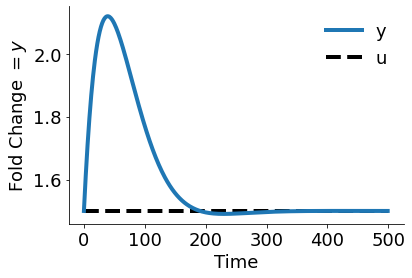

In [170]:
# first reference curve is generated by a second order system

# we need the parameter zeta (damping coefficient) to be greater than 0 and less than 1 for the second order
# constant coefficient system to be underdamped (all poles lie on left half of unit circle in s-plane)

sampling_rate = 3 # sampling frequency in minutes
tSpan = np.linspace(0,nSamples*sampling_rate,nSamples)/60 # represent time in hours

zeta = 0.8 # if low, oscillations
m = 10 # if low, low variance peak
k = 3 # similar effect to m 
omega_n = np.sqrt(k/m)
sigma = zeta*omega_n
omega_d = omega_n*np.sqrt(1-zeta**2)
x0 = 0.0
v0 = 1.6
t = deepcopy(tSpan)
alpha = x0/2
beta = -(v0+sigma*x0)/(2*omega_d)
u = 1.5

y = np.exp(-sigma*t)*(alpha*np.cos(omega_d*t) - beta*np.sin(omega_d*t)) + u

plt.figure();
plt.plot(y,label='y');
plt.hlines(u,0,len(tSpan),linestyles='dashed',color='k',label='u');
plt.legend(frameon=False);
plt.ylabel(r'Fold Change $= y$');
plt.xlabel('Time');

In [171]:
beta = cp.Variable(S.shape[1],nonneg=True) # decision variable, must always be nonnegative
lambd = cp.Parameter(nonneg=True) # regularization parameter which is nonnegative 
problem = cp.Problem(cp.Minimize(objective_fn(S, y, beta, lambd))) # minimize the mse objective function with reg

lambd_values = np.logspace(-5,2,9) # scan across lambda
train_errors = []
test_errors = []
beta_values = []
for v in lambd_values:
    lambd.value = v
    problem.solve(solver='SCS',verbose=True)
    train_errors.append(mse(S, y, beta))
    beta_values.append(beta.value)

----------------------------------------------------------------------------
	SCS v2.1.2 - Splitting Conic Solver
	(c) Brendan O'Donoghue, Stanford University, 2012
----------------------------------------------------------------------------
Lin-sys: sparse-direct, nnz in A = 7579
eps = 1.00e-04, alpha = 1.50, max_iters = 5000, normalize = 1, scale = 1.00
acceleration_lookback = 10, rho_x = 1.00e-03
Variables n = 32, constraints m = 549
Cones:	linear vars: 45
	soc vars: 504, soc blks: 2
Setup time: 1.75e-03s
----------------------------------------------------------------------------
 Iter | pri res | dua res | rel gap | pri obj | dua obj | kap/tau | time (s)
----------------------------------------------------------------------------
     0| 6.42e+19  4.84e+19  1.00e+00 -3.79e+20  7.81e+18  2.30e+20  1.01e-03 
   100| 2.04e-05  1.02e-04  1.48e-05  3.67e-01  3.67e-01  1.47e-16  5.88e-03 
   160| 1.26e-05  3.42e-05  4.64e-06  3.67e-01  3.67e-01  2.99e-17  9.19e-03 
---------------------

----------------------------------------------------------------------------
Error metrics:
dist(s, K) = 6.3382e-16, dist(y, K*) = 2.2204e-16, s'y/|s||y| = 6.7176e-17
primal res: |Ax + s - b|_2 / (1 + |b|_2) = 2.8310e-05
dual res:   |A'y + c|_2 / (1 + |c|_2) = 6.7893e-05
rel gap:    |c'x + b'y| / (1 + |c'x| + |b'y|) = 2.6763e-05
----------------------------------------------------------------------------
c'x = 0.4121, -b'y = 0.4121
----------------------------------------------------------------------------
	SCS v2.1.2 - Splitting Conic Solver
	(c) Brendan O'Donoghue, Stanford University, 2012
----------------------------------------------------------------------------
Lin-sys: sparse-direct, nnz in A = 7579
eps = 1.00e-04, alpha = 1.50, max_iters = 5000, normalize = 1, scale = 1.00
acceleration_lookback = 10, rho_x = 1.00e-03
Variables n = 32, constraints m = 549
Cones:	linear vars: 45
	soc vars: 504, soc blks: 2
Setup time: 2.21e-03s
SCS using variable warm-starting
-----------------

In [172]:
kk = -1 # picked this model based on two above plots
coeff_thresh = 0.1# only select strain if weight is greater than coeff_thresh
vs_inds = [ii for ii,coeff in enumerate(beta_values[kk]) if coeff > coeff_thresh]
vs_inds

beta = deepcopy(beta_values[kk])
(beta)[beta < coeff_thresh] = 0 # sparse vector of coefficients
print([vs_strains[ii] for ii in vs_inds])
print([np.round(beta_values[kk][ii],2) for ii in vs_inds])

['4150_5', '4736_5', '1380_5']
[0.26, 0.31, 0.6]


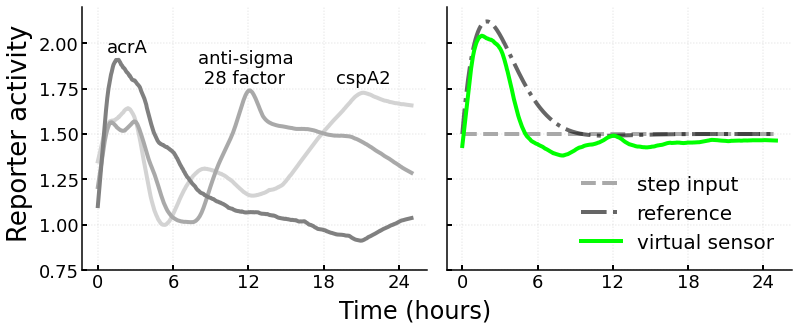

In [174]:
savefig = False

fig, axs = plt.subplots(1,2,figsize=(11,4.5),sharey=True)

axs[1].plot(tSpan,u*np.ones_like(tSpan),'--',lw=4,color='darkgray')
axs[1].plot(tSpan,y,'-.',lw=4,color='k',alpha=0.6)
axs[1].plot(tSpan, savgol(S @ beta,25,1),'-',lw=4,label='',color='lime')
axs[1].set_ylim(0.75,2.2)
axs[1].legend(['step input','reference','virtual sensor'],loc='lower right',frameon=False,fontsize=20);
colors = ['lightgray','darkgray','gray']
for ii in range(len(vs_inds)):
    axs[0].plot(tSpan,savgol(S[:,vs_inds[ii]],21,1),c=colors[ii]) # c=npg_colors[ii]
    
for ax in axs.reshape(-1):
    for side in ax.spines.keys():
        ax.spines[side].set_linewidth(1.5)
    ax.xaxis.set_tick_params(which='both', size=5, width=2, direction='in')
    ax.yaxis.set_tick_params(which='both', size=5, width=2, direction='in')
    ax.grid(linestyle=':',linewidth=.3,dashes=(5,5))

fs = 18
axs[0].text(0.7,1.95,'acrA',fontsize=fs)
axs[0].text(19,1.775,'cspA2',fontsize=fs)
axs[0].text(8,1.775,'anti-sigma \n 28 factor',fontsize=fs)

axs[0].set_xticks([0,6,12,18,24])
axs[1].set_xticks([0,6,12,18,24])

fig.text(0.5, -0.02, 'Time (hours)', ha='center',fontsize=24)
fig.text(-0.015, 0.55, 'Reporter activity', va='center', rotation='vertical',fontsize=26)        
plt.tight_layout()
# plt.legend()
if savefig: 
    figDir = '/Users/aqib/Desktop/BCCL/koopman-sensor-placement/NC_submission/figures/fig5/'
    plt.savefig(figDir + 'second_order_vs.pdf',bbox_inches='tight',transparent=True,dpi=300)
plt.show()

#### Sum of rbs shifted in time (reference)

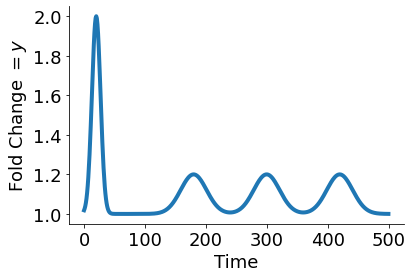

In [175]:
y1 = 1*np.exp(-((t - 1)/0.5)**2) + 1.0
y2 = 0.2*np.exp(-((t - 9)/1.5)**2) 
y3 = 0.2*np.exp(-((t - 15)/1.5)**2) 
y4 = 0.2*np.exp(-((t - 21)/1.5)**2) 

y = y1+y2+y3+y4

plt.figure();
plt.plot(y);
plt.ylabel(r'Fold Change $= y$');
plt.xlabel('Time');


In [176]:
beta = cp.Variable(S.shape[1],nonneg=False) # decision variable, must always be nonnegative
lambd = cp.Parameter(nonneg=True) # regularization parameter which is nonnegative 
problem = cp.Problem(cp.Minimize(objective_fn(S, y, beta, lambd))) # minimize the mse objective function with reg

lambd_values = np.logspace(-5,2,9) # scan across lambda
train_errors = []
test_errors = []
beta_values = []
for v in lambd_values:
    lambd.value = v
    problem.solve(solver='SCS',verbose=True)
    train_errors.append(mse(S, y, beta))
    beta_values.append(beta.value)

----------------------------------------------------------------------------
	SCS v2.1.2 - Splitting Conic Solver
	(c) Brendan O'Donoghue, Stanford University, 2012
----------------------------------------------------------------------------
Lin-sys: sparse-direct, nnz in A = 7564
eps = 1.00e-04, alpha = 1.50, max_iters = 5000, normalize = 1, scale = 1.00
acceleration_lookback = 10, rho_x = 1.00e-03
Variables n = 32, constraints m = 534
Cones:	linear vars: 30
	soc vars: 504, soc blks: 2
Setup time: 2.04e-03s
----------------------------------------------------------------------------
 Iter | pri res | dua res | rel gap | pri obj | dua obj | kap/tau | time (s)
----------------------------------------------------------------------------
     0| 5.37e+19  4.13e+19  1.00e+00 -2.24e+20  2.86e+19  1.67e+20  1.19e-03 
   100| 2.44e-04  1.71e-03  1.35e-04  2.55e+00  2.55e+00  5.75e-17  6.61e-03 
   140| 1.95e-05  5.07e-05  5.81e-07  2.55e+00  2.55e+00  7.32e-17  9.04e-03 
---------------------

/usr/local/lib/python3.8/site-packages/cvxpy/problems/problem.py:1060: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


     0| 3.00e-03  5.76e-03  4.56e-04  2.54e+00  2.54e+00  5.51e-17  1.64e-03 
    40| 4.19e-06  6.74e-06  1.71e-06  2.58e+00  2.58e+00  1.91e-17  3.96e-03 
----------------------------------------------------------------------------
Status: Solved
Timing: Solve time: 3.97e-03s
	Lin-sys: nnz in L factor: 8250, avg solve time: 1.47e-05s
	Cones: avg projection time: 7.15e-07s
	Acceleration: avg step time: 2.76e-05s
----------------------------------------------------------------------------
Error metrics:
dist(s, K) = 1.8140e-18, dist(y, K*) = 4.4409e-16, s'y/|s||y| = 4.8313e-16
primal res: |Ax + s - b|_2 / (1 + |b|_2) = 4.1909e-06
dual res:   |A'y + c|_2 / (1 + |c|_2) = 6.7396e-06
rel gap:    |c'x + b'y| / (1 + |c'x| + |b'y|) = 1.7141e-06
----------------------------------------------------------------------------
c'x = 2.5781, -b'y = 2.5781
----------------------------------------------------------------------------
	SCS v2.1.2 - Splitting Conic Solver
	(c) Brendan O'Donoghue, Stanford 

In [177]:
kk = 0 # picked this model based on two above plots
coeff_thresh = 0.000001# only select strain if weight is greater than coeff_thresh
vs_inds = [ii for ii,coeff in enumerate(beta_values[kk]) if coeff > coeff_thresh]
print(vs_inds)
beta = deepcopy(beta_values[kk])
(beta)[beta < coeff_thresh] = 0 # sparse vector of coefficients

[0, 2, 3, 4, 6, 7, 8, 11, 14]


['4150_5', '1358_5', '5502_5', '1823_5', '1836_5', '0376_5', '4736_5', '1380_5', '0953_5']
[0.74, 0.51, 0.1, 0.32, 0.11, 1.29, 0.13, 0.36, 0.5]


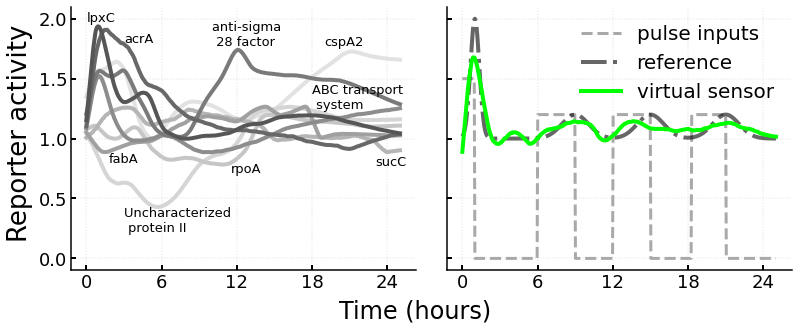

In [179]:
step_input = np.zeros_like(tSpan)
step_input[0:20] = 1.5
step_input[120:180] = 1.2
step_input[240:300] = 1.2
step_input[365:420] = 1.2

savefig = False

print([vs_strains[ii] for ii in vs_inds])
print([np.round(beta_values[kk][ii],2) for ii in vs_inds])

fig, axs = plt.subplots(1,2,figsize=(11,4.5),sharey=True)
cmap = cm.get_cmap('Greys')
grad_colors = [list(cmap(x)[0:3]) for x in np.linspace(0.2,0.8,10)]
axs[1].plot(tSpan,step_input,'--',lw=3,color='darkgray')
axs[1].plot(tSpan,y,'-.',lw=4,color='k',alpha=0.6)
axs[1].plot(tSpan, savgol(S @ beta_values[0],19,1),'-',lw=4,color='lime')
if len(vs_inds) <= len(npg_colors):
    my_colors = npg_colors
else: 
    my_colors = ['tab:blue']*len(vs_inds)
for ii in range(len(vs_inds)):
    axs[0].plot(tSpan,savgol(S[:,vs_inds[ii]],21,1),c=grad_colors[ii]) # c=my_colors[ii]
    
for ax in axs.reshape(-1):
    for side in ax.spines.keys():
        ax.spines[side].set_linewidth(1.5)
    ax.xaxis.set_tick_params(which='both', size=5, width=2, direction='in')
    ax.yaxis.set_tick_params(which='both', size=5, width=2, direction='in')
    ax.grid(linestyle=':',linewidth=.3,dashes=(5,5))
    
axs[0].set_xticks([0,6,12,18,24])
axs[1].set_xticks([0,6,12,18,24])

fs = 13
axs[0].text(0,1.975,'lpxC',fontsize=fs) 
axs[0].text(3,1.8,'acrA',fontsize=fs)    
axs[0].text(11.5,0.72,'rpoA',fontsize=fs)    
axs[0].text(3,.225,'Uncharacterized \n protein II',fontsize=fs) 
axs[0].text(10,1.775,'anti-sigma \n 28 factor',fontsize=fs)
axs[0].text(19,1.775,'cspA2',fontsize=fs)
axs[0].text(23,0.775,'sucC',fontsize=fs)
axs[0].text(1.8,0.8,'fabA',fontsize=fs)
axs[0].text(18,1.25,'ABC transport \n system',fontsize=fs)
fig.text(0.5, -0.02, 'Time (hours)', ha='center',fontsize=24)
fig.text(-0.015, 0.55, 'Reporter activity', va='center', rotation='vertical',fontsize=26)        
axs[1].legend(['pulse inputs','reference','virtual sensor'],frameon=False,fontsize=20);
plt.tight_layout()

if savefig: 
    figDir = '/Users/aqib/Desktop/BCCL/koopman-sensor-placement/NC_submission/figures/fig5/'
    plt.savefig(figDir + 'gaussian_peak_vs.pdf',bbox_inches='tight',transparent=True,dpi=300)
plt.show()

#### Cluster the reporters based on time-series profiles

In [ ]:
vs_names = ['cspA2','petA','uncharacterized protein II','rpoA','sucC','atpB',
 'Putative ABC transport system','fabA','anti-sigma 28 factor','gltA','acrA',
 'Putative outer membrane porin A',
 'uncharacterized protein I','capB','lpxC']

In [ ]:
plt.figure(figsize=(5,8))
correlations = pd.DataFrame(S).corr()
dissimilarity = 1 - abs(correlations)
Z = linkage(squareform(dissimilarity), 'complete')
dendrogram(Z, labels=vs_names, orientation='right',leaf_rotation=0,leaf_font_size=18);

In [ ]:
# Clusterize the data
threshold = 0.2
labels = fcluster(Z, threshold, criterion='distance')

# Show the cluster
labels

In [ ]:
# Keep the indices to sort labels
labels_order = np.argsort(labels)

S_clustered = pd.DataFrame(S[:,labels_order])
clustered_correlations = S_clustered.corr()

vs_names = ['cspA2','petA','uncharacterized protein II','rpoA','sucC','atpB',
 'Putative ABC transport system','fabA','anti-sigma 28 factor','gltA','acrA',
 'Putative outer membrane porin A',
 'uncharacterized protein I','capB','lpxC']

vs_names_clustered = [vs_names[ii] for ii in labels_order]

savefig = False

plt.rcParams.update({'font.size':18});

cmap = sns.diverging_palette(20, 230, as_cmap=True)
plt.figure(figsize=(10,8));
ax = sns.heatmap(round(clustered_correlations,1), cmap=cmap, annot=False,
            annot_kws={"size":8}, vmin=-1, vmax=1,xticklabels=vs_names_clustered, linewidths=1,
           yticklabels=vs_names_clustered,cbar_kws={'label': 'Pearson correlation'});

ax.axhline(y=0, color='k',linewidth=6)
ax.axhline(y=clustered_correlations.shape[1], color='k',linewidth=6)
ax.axvline(x=0, color='k',linewidth=6)
ax.axvline(x=clustered_correlations.shape[0], color='k',linewidth=6)

if savefig: 
    figDir = '/Users/aqib/Desktop/BCCL/koopman-sensor-placement/NC_submission/figures/fig5/'
    plt.savefig(figDir + 'clustered_correlations.pdf',bbox_inches='tight',transparent=True,dpi=300)
plt.show()